# Milestone Project: Food Vision Big

## Check GPU

Google Colab offers free GPUs, however, not all of them are compatiable with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to Tesla T4 (from within Google Colab) or if we're using our iwn hardware, our GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-gpus).

In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-117ef0f2-3c31-8ca3-8ca0-3b671cb81f7d)


## Get helper functions

In past modules, we've created a bunch of helper functions to do smaill tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script we've got avalible can be found on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

In [2]:
# Download helper function script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-30 03:06:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-30 03:06:28 (47.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Create TensorBoard callback function
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [4]:
# Plot Loss curves function
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [5]:
# Compare History function
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## Use TensorFlow Datasets to Download Data

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview

In [6]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [7]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print('food101' in datasets_list) # is our target dataset in the list of TFDS dataset?

True


In [8]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteNU3NWL/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteNU3NWL/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do this labels match up with the class names?



In [9]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [10]:
# Get the class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [11]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # sample are in format (image_tensor, label)

In [12]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [13]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image Shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image Shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 41
  Class name (str form): french_onion_soup
  


In [14]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 85,  52,  35],
        [ 76,  43,  26],
        [ 65,  33,  18],
        ...,
        [122,  68,  24],
        [ 99,  47,   8],
        [ 98,  48,  13]],

       [[ 75,  42,  25],
        [ 67,  34,  17],
        [ 61,  29,  14],
        ...,
        [122,  68,  24],
        [100,  48,   9],
        [ 95,  45,  10]],

       [[ 72,  39,  20],
        [ 64,  31,  12],
        [ 62,  31,  13],
        ...,
        [130,  73,  30],
        [106,  52,  14],
        [ 95,  42,   8]],

       ...,

       [[130,  82,  16],
        [140,  89,  32],
        [129,  71,  34],
        ...,
        [ 90,  53,  24],
        [ 83,  48,  20],
        [ 92,  57,  29]],

       [[131,  86,  18],
        [139,  90,  32],
        [127,  71,  34],
        ...,
        [ 93,  56,  27],
        [ 73,  38,  10],
        [ 92,  58,  30]],

       [[127,  84,  15],
        [132,  86,  26],
        [122,  66,  29],
        ...,
        [ 93,  58,  2

In [15]:
# what are the min and max values of our image tensor?

#tf.reduce_min(image), tf.reduce_max(image)

In [16]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image), tf.__version__ 

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>,
 '2.6.0')

### Plot an image from TensorFlow Datasets

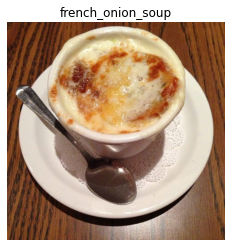

In [17]:
# Plot an image tensor 
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False);

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values batween 0 & 1) also called normalized tensors generally perform better

With these points in mind, we'be got a few things we can tackle with a preprocessing funtion.

Since we're going to be using an EfficientNeyBX pretrained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions needs to:
1. Reshape our images to all the same size 
2. Convert the dtype of our image tensors from `uint8` to `float32`


In [18]:
# Make a function for preprocessing images
def preprocessing_img(image, label, img_shape=224):
  """
  Converts image datatype from `uint8` -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # resize target image
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [19]:
# Preprocess a single image and check the outputs
preprocessed_img = preprocessing_img(image, label)[0]
print(f'Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}')
print(f'Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}')

Image before preprocessing:
 [[[ 85  52  35]
  [ 76  43  26]
  [ 65  33  18]
  ...
  [122  68  24]
  [ 99  47   8]
  [ 98  48  13]]

 [[ 75  42  25]
  [ 67  34  17]
  [ 61  29  14]
  ...
  [122  68  24]
  [100  48   9]
  [ 95  45  10]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>
Image after preprocessing:
 [[[ 73.198975  40.19898   23.198978]
  [ 68.13266   36.132656  21.132654]
  [ 63.92347   34.27551   23.5051  ]
  ...
  [142.72447   80.72447   23.163235]
  [129.42847   71.71423   22.142883]
  [ 98.367226  47.081577   9.510289]]

 [[ 62.744896  29.744898  10.744897]
  [ 70.55613   39.357147  21.62245 ]
  [ 63.7551    34.683674  20.897957]
  ...
  [146.44394   83.515366  29.301085]
  [135.9694    75.18882   28.341953]
  [106.24939   51.08109   15.106708]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch & prepare datasets

We're now going to make our data input pipeline run really fast.

For more resources on this, I'd highly going through the following guide: https://www.tensorflow.org/guide/data_performance

In [20]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [21]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

> "Hey, TensorFlow, map this preprocessing function (preprocess_img) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch."

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progess after feature extraction


In [22]:
# Create tensorboard callback (import from helper function)
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instance to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [23]:
# Create ModelCheckpoint callback to save model's progress during training
checkpoint_path = 'model_checkpoint/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='vall_acc',
                                                      save_best_only=True,
                                                      save_weight_only=True,
                                                      verbose=0) # don't print whether or not model is being saved

## Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision

Mixed precison utilizes a combination of float32 and float16 data types to speed up model performance.

In [24]:
# Turn on mixed precision training 
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16') # set global data policy to mixed precision

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [25]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [26]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model 
inputs = layers.Input(shape=input_shape, name='input_layer')
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # makes sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

16719872/16705208 [==============================] - 1s 0us/step


In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


## Checking layer dtype policies (are we using mixed precision?)

In [28]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainble`: is the layer trainable or not? (if `False`, the weights are frozen)
* `layer.dtype`: the data type a layer stores its variables in 
* `layer.dtype_policy` the data type policy a layer computes on its variables with

In [29]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers[:20]: # Check the layers of the base model (layer at index 1 of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

In [30]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of frozen layers

In [31]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [32]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name='training_logs',
                                                                                            experiment_name='efficientb0_101_classes_all_data_feature_extract'),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_feature_extract/20211030-031436
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 301s 108ms/step - loss: 1.8207 - accuracy: 0.5568 - val_loss: 1.2252 - val_accuracy: 0.6724


Epoch 2/3
2368/2368 [==============================] - 245s 103ms/step - loss: 1.2933 - accuracy: 0.6667 - val_loss: 1.1435 - val_accuracy: 0.6939


Epoch 3/3
2368/2368 [==============================] - 244s 102ms/step - loss: 1.1431 - accuracy: 0.7024 - val_loss: 1.0851 - val_accuracy: 0.7119


In [33]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 81s 103ms/step - loss: 1.0851 - accuracy: 0.7095


[1.085053563117981, 0.7095049619674683]

## Fine-tune model

In [34]:
# Create fine-tuning model
fine_tune_model = model
fine_tune_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [35]:
# Set all layer trainable to True
for layer in fine_tune_model.layers:
  layer.trainable = True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [36]:
# Check the layers in the base model and see what dtype policy they're using
for layer in fine_tune_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed

In [37]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [38]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [39]:
# Compile the model
fine_tune_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [40]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = fine_tune_model.fit(train_data,
                                                        epochs=5, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20211030-033011
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 1168s 480ms/step - loss: 0.9200 - accuracy: 0.7544 - val_loss: 0.7874 - val_accuracy: 0.7860
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
2368/2368 [==============================] - 1117s 471ms/step - loss: 0.5781 - accuracy: 0.8393 - val_loss: 0.7672 - val_accuracy: 0.7948
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/5
2368/2368 [==============================] - 1130s 476ms/step - loss: 0.3287 - accuracy: 0.9065 - val_loss: 0.8448 - val_accuracy: 0.7913
Epoch 4/5
2368/2368 [==============================] - 1141s 481ms/step - loss: 0.1739 - accuracy: 0.9485 - val_loss: 0.9858 - val_accuracy: 0.7765

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 5/5
2368/2368 [==============================] - 1117s 471ms/step - loss: 0.0350 - accuracy: 0.9922 - val_loss: 1.0360 - val_accuracy: 0.8061


In [41]:
# Evaluate model on whole test dataset
results_fine_tuned_model = fine_tune_model.evaluate(test_data)
results_fine_tuned_model

790/790 [==============================] - 74s 94ms/step - loss: 1.0383 - accuracy: 0.8010


[1.038292407989502, 0.800990104675293]

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
# Save our model fine-tuning model
fine_tune_model.save('/content/drive/MyDrive/Food101_fine_tuned')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food101_fine_tuned/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food101_fine_tuned/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [45]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Food101_fine_tuned')

In [46]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 77s 95ms/step - loss: 1.0383 - accuracy: 0.8010


[1.0382920503616333, 0.800990104675293]

In [47]:
results_fine_tuned_model

[1.038292407989502, 0.800990104675293]

In [48]:
# Save our model feature extraction model
model.save('/content/drive/MyDrive/Food101_feature_extraction')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food101_feature_extraction/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food101_feature_extraction/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
